### 1. sub classing API

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

class MyModel(Model):
    # 사용할 층 정의
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.first_conv = Conv2D(32, (3, 3), activation = "relu")
        self.second_conv = Conv2D(32, (3, 3), activation = "relu")
        self.maxpool = MaxPooling2D(strides = 2)
        
        self.gap = GlobalAveragePooling2D()
        self.dense = Dense(1, activation = "sigmoid")
    
    # forward pass 흐름 정의
    def call(self, inputs):
        x = self.first_conv(inputs)
        x = self.second_conv(x)
        x = self.maxpool(x)
        
        x = self.gap(x)
        x = self.dense(x)
        
        return x
    
model = MyModel()

### 2. multiple input/output with functional API

In [2]:
# create virtual data
import numpy as np

input1_images = np.random.random((1000, 28, 28, 1))
input2_reviews = np.random.randint(10000, size = (1000, 100)) 

output1_rate = np.round(np.random.random((1000,))*5, 1)
output2_needed = np.random.randint(50, size = (1000,))

print(input1_images.shape, input2_reviews.shape)
print(output1_rate.shape, output2_needed.shape)

(1000, 28, 28, 1) (1000, 100)
(1000,) (1000,)


In [7]:
# build multi-io model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers import Dense, Concatenate

# define two input
img_input = Input(shape = (28, 28, 1), name = "image")
review_input = Input(shape = (None, ), name = "review")

# image processing
x_1 = Conv2D(32, (3, 3), activation = 'relu')(img_input)
x_1 = Conv2D(32, (3, 3), activation = 'relu')(x_1)
x_1 = MaxPooling2D(strides = 2)(x_1)
x_1 = GlobalAveragePooling2D()(x_1)

# review processing
x_2 = Embedding(10000, 64)(review_input)
x_2 = LSTM(128)(x_2)

# concat two input
x = Concatenate()([x_1, x_2])

# define two output
rate_pred = Dense(1, name = 'rate')(x)
needed_pred = Dense(50, activation = 'softmax', name = 'needed')(x)

# create model
model = Model(inputs = [img_input, review_input],
             outputs = [rate_pred, needed_pred])

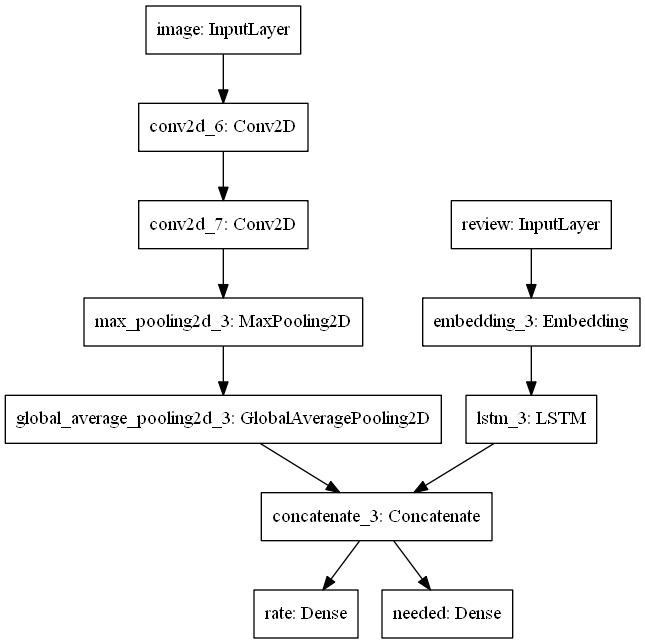

In [8]:
plot_model(model)

In [ ]:
# loss - output 층마다 적절한 형태의 loss function mapping
model.compile(optimizer = 'adam', 
             loss = {'rate':'mse', 'needed':'sparse_categorical_crossentropy'}, 
             metrics = {'rate':'mse', 'needed':'acc'})

# fit - 각 IO layer과 실제 다중입력데이터, 다중출력레이블들 각각을 딕셔너리 매핑으로 전달
model.fit({'image':input1_images, 'review':input2_reviews}, 
          {'rate':output1_rate, 'update_for_hamburger':output2_needed},
         epochs = 2, batch_size = 32)

### 3. Residual Network

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Add
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# original resnet은 maxpooling 대신 stride 2 conv로 downsampling 수행
def residual_block(inputs, num_channels, downsampling = False):
    x = Conv2D(num_channels, (3, 3), activation = "relu",
               padding = "same")(inputs)
    x = Conv2D(num_channels, (3, 3), padding = "same")(x)
    
    # pooling에 의해 downsampling 진행될 경우 1*1 conv를 통해 input의 형태 조절
    if downsampling:
        x = MaxPooling2D(strides = 2)(x)
        inputs = Conv2D(num_channels, (1, 1), strides = 2,
                        padding = "same")(inputs)
        
    # 원본 입력과 변환된 입력을 더한다 (element-wise)
    # broadcast 발생
    add_x = Add()([inputs, x])
    
    return Activation("relu")(add_x)


inputs = Input(shape = (28, 28, 1))
x = residual_block(inputs, 32, downsampling = True)
x = residual_block(x, 32)
x = residual_block(x, 32, downsampling = True)

x = GlobalAveragePooling2D()(x)
x = Dense(10, activation = "softmax")(x)

model = Model(inputs = inputs, outputs = x)

In [11]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 32)   64          input_1[0][0]                    
____________________________________________________________________________________________

### 4. inception module
* use filters of various sizes -> capture various features
* dimentionality reduction by 1by1 conv

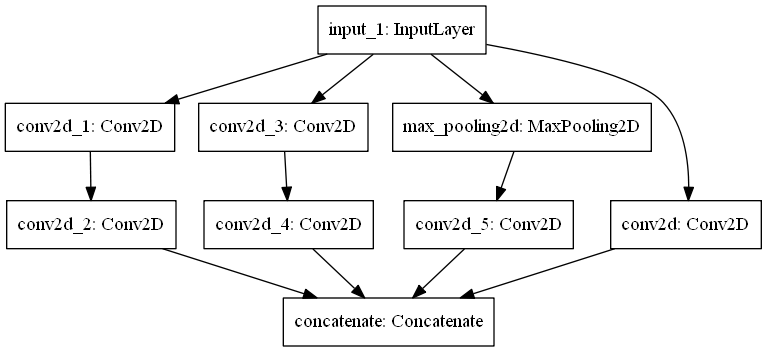

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Concatenate
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def inception_module(x):
    x_1 = Conv2D(32, (1,1), activation = "relu")(x)
    
    x_2 = Conv2D(48, (1,1), activation = "relu")(x)
    x_2 = Conv2D(64, (3,3), activation = "relu", padding = "same")(x_2)
    
    x_3 = Conv2D(16, (1,1), activation = "relu")(x)
    x_3 = Conv2D(16, (5,5), activation = "relu", padding = "same")(x_3)
    
    x_4 = MaxPooling2D(pool_size = (3, 3), strides = 1, padding = "same")(x)
    x_4 = Conv2D(32, (1,1), activation = "relu")(x_4)
    
    output = Concatenate()([x_1, x_2, x_3, x_4])
    
    return output

inputs = Input(shape = (224, 224, 3))
x = inception_module(inputs)

model = Model(inputs = inputs, outputs = x)



from tensorflow.keras.utils import plot_model
plot_model(model)

In [2]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 192         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 224, 224, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 224, 224, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

### 5. transfer learning with tf hub & keras applications

In [ ]:
# keras app
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def get_model(num_classes):
    resnet = ResNet50(weights = "imagenet", include_top = False, 
                      input_shape = (32, 32, 3))
    
    # connect loaded model's output with task specific clf head 
    x = GlobalAveragePooling2D()(resnet.output)
    x = Dense(num_classes, activation = "softmax")(x)
    
    # model build
    model = Model(inputs = resnet.input, outputs = x)
    return model
    
model = get_model(num_classes=10)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [3]:
# -------------------------------
# tf hub
# -------------------------------

# data loading
from tensorflow.keras.datasets import cifar10
import numpy as np
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# channel wise standardization
x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.3)
print(x_train.shape, len(y_train))
print(x_val.shape, len(y_val))

img_shape = x_train.shape[1:]

# use tf hub model
import tensorflow_hub as hub

# hub.KerasLayer : Wraps a SavedModel as a Keras Layer.
model_url = "https://tfhub.dev/google/efficientnet/b0/classification/1"
hub_layer = hub.KerasLayer(model_url, trainable = False, input_shape = img_shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

model = Sequential([
    hub_layer,
    Dense(10, activation = 'softmax')])

model.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'],
              optimizer = 'adam')

# model.build((None, ) + img_shape)

model.fit(x_train, y_train, epochs = 1,
          batch_size = 32, validation_data = (x_val, y_val))

(35000, 32, 32, 3) 35000
(15000, 32, 32, 3) 15000
1094/1094 [==============================] - 114s 97ms/step - loss: 2.3190 - acc: 0.1821 - val_loss: 2.2388 - val_acc: 0.2103
